In [2]:
!pip install -U accelerate
!pip install -U transformers

In [3]:
import pandas as pd
df = pd.read_csv("./dataset/problems.csv", usecols=["description", "labels"])
df.head()
df['labels'][2]

"['greedy', 'sorting']"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10912 entries, 0 to 10911
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  10912 non-null  object
 1   labels       10912 non-null  object
dtypes: object(2)
memory usage: 170.6+ KB


<Axes: ylabel='Frequency'>

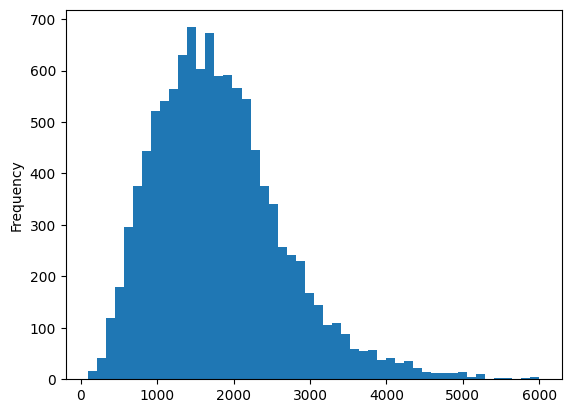

In [4]:
# df.shape
df.info()
# df.duplicated().sum()
df['description'].str.len().plot.hist(bins=50)

In [5]:
import ast

df['labels'] = df['labels'].apply(ast.literal_eval)
labels_cnt = [l for lab in df['labels'] for l in lab]
label_series = pd.Series(labels_cnt).value_counts()
print(label_series)

print("總共有", label_series.index.nunique(), "種 labels")

math                   3466
greedy                 3293
data structures        2710
dynamic programming    2630
graphs                 1950
sorting                1488
strings                1415
binary search          1366
trees                  1055
number theory           819
bit manipulation        785
combinatorics           736
two pointers            732
union find              424
geometry                411
divide and conquer      334
matrices                333
shortest path           289
game theory             257
hashing                 239
probabilities           229
interactive             210
Name: count, dtype: int64
總共有 22 種 labels


In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel = MultiLabelBinarizer()
labels = multilabel.fit_transform(df["labels"]).astype('float32')  # To align label format with model prediction (both are float)
texts = df["description"].tolist()
# labels
# texts[:5]


In [7]:
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import numpy as np

In [8]:

import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

texts_np = np.array(texts)  # 假設 texts 是 list[str]
labels_np = np.array(labels)  # 假設 labels 是 np.ndarray [N, C] multi-hot

# MIN_VAL_COUNT = 40
# for i in range(100):  # 最多嘗試 100 次
    
#     val_counts = np.sum(y_val, axis=0)
#     if np.all(val_counts >= MIN_VAL_COUNT):
#         print(f"Valid split found at iteration {i}")
#         break
X_train, y_train, X_val, y_val = iterative_train_test_split(
        texts_np.reshape(-1, 1), labels_np, test_size=0.2
    )
# 還原回原本格式
train_texts = X_train.ravel().tolist()
val_texts = X_val.ravel().tolist()
train_labels = y_train
val_labels = y_val

# 統計出現次數
train_labels_cnt = np.sum(train_labels, axis=0)
val_label_counts = np.sum(val_labels, axis=0)

print("Train label counts:", train_labels_cnt)
print("Val label counts:", val_label_counts)




Train label counts: [1093.  628.  584. 2168.  262. 2104.  206.  329. 1560. 2634.  189.  168.
 2773.  266.  654.  182.  231. 1190. 1132.  844.  586.  339.]
Val label counts: [273. 157. 152. 542.  72. 526.  51.  82. 390. 659.  50.  42. 693.  67.
 165.  47.  58. 298. 283. 211. 146.  85.]


In [9]:
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]),
                                                            problem_type="multi_label_classification")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [11]:
# Lets build custom dataset
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }

train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [12]:
val_dataset[0]

{'input_ids': tensor([  101,  3021,  2003,  1037,  3297, 13235,  1999, 11957,  3122,  1012,
          4283,  2000,  2010,  6208,  8785, 15636,  2002,  2001,  2583,  2000,
          2191,  2438,  2769,  2000,  3857,  1037,  3376,  2160,  1012,  6854,
          1010,  2005,  2025,  7079,  3200,  4171,  2006,  2051,  1010,  2457,
          2787,  2000, 16385,  3021,  2011,  2437,  2032,  4558,  1037,  2112,
          1997,  2010,  3200,  1012,  3021,  1521,  1055,  3200,  2064,  2022,
          5159,  2004,  1037, 18309,  3180,  1016,  2078,  1011, 11536, 26572,
          7446,  1037,  2692, 17350,  1012,  1012,  1012, 22441,  2078,  1011,
          1015, 22441,  2078,  1010, 22441,  2078,  1027,  1037,  2692,  1010,
          2007,  3903,  1997,  1996,  3599,  1015,  8316,  1999,  3091,  1012,
          2457,  3513,  2005,  9268,  2112,  1997,  2010,  3200,  2024,  2004,
          4076,  1024,  1011,  3975,  2296,  3341, 17712, 17712,  1009,  1015,
          1010,  1047,  1027,  1014,  1

In [38]:
# Multi-Label Classification Evaluation Metrics
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss, roc_curve
from transformers import EvalPrediction
import torch


def find_optimal_thresholds(y_true, y_probs):
    thresholds = []
    for i in range(y_true.shape[1]):
        fpr, tpr, th = roc_curve(y_true[:, i], y_probs[:, i])
        youdens_j = tpr - fpr
        best_th = th[np.argmax(youdens_j)]
        thresholds.append(best_th)
    print("Optimal thresholds:", thresholds)
    return np.array(thresholds)


def multi_labels_metrics(predictions, labels):
    sigmoid = torch.nn.Sigmoid()
    #   probs = sigmoid(torch.Tensor(predictions))
    probs = sigmoid(torch.tensor(predictions)).detach().cpu().numpy()

    y_pred = np.zeros(probs.shape)
    # thresholds = np.full(probs.shape[1], 0.3)
    
    thresholds = np.maximum(find_optimal_thresholds(labels,probs), 0.05)

    # y_pred[np.where(probs>=threshold)] = 1
    y_pred = (probs >= thresholds).astype(int)
    y_true = labels

    f1 = f1_score(y_true, y_pred, average = 'macro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    hamming = hamming_loss(y_true, y_pred)

    metrics = {
        "roc_auc": roc_auc,
        "hamming_loss": hamming,
        "f1": f1
    }

    return metrics

def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  
  result = multi_labels_metrics(predictions=preds,labels=p.label_ids)

  return result

In [39]:
# Training Arguments
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    num_train_epochs=5,
    save_steps=1000,
    save_total_limit=2
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics)

In [15]:
trainer.train()

Step,Training Loss
500,0.297300
1000,0.254500
1500,0.241400
2000,0.230700
2500,0.219500
3000,0.207400
3500,0.195200
4000,0.182900
4500,0.175100
5000,0.159200


TrainOutput(global_step=5455, training_loss=0.21150065700905132, metrics={'train_runtime': 719.1329, 'train_samples_per_second': 60.67, 'train_steps_per_second': 7.586, 'total_flos': 1445403501419520.0, 'train_loss': 0.21150065700905132, 'epoch': 5.0})

In [40]:
trainer.evaluate()

Optimal thresholds: [np.float32(0.12036975), np.float32(0.13050556), np.float32(0.06791906), np.float32(0.1771556), np.float32(0.027536802), np.float32(0.21916242), np.float32(0.031269856), np.float32(0.020125106), np.float32(0.19741565), np.float32(0.18488069), np.float32(0.016853461), np.float32(0.08915222), np.float32(0.2966078), np.float32(0.027958767), np.float32(0.23972923), np.float32(0.019208778), np.float32(0.027228631), np.float32(0.076017484), np.float32(0.041665774), np.float32(0.10833892), np.float32(0.07005806), np.float32(0.021570968)]


{'eval_loss': 0.25740012526512146,
 'eval_model_preparation_time': 0.0027,
 'eval_roc_auc': 0.7210570106977301,
 'eval_hamming_loss': 0.17601680113116527,
 'eval_f1': 0.4123475725889586,
 'eval_runtime': 18.3728,
 'eval_samples_per_second': 118.98,
 'eval_steps_per_second': 14.913}

# roc Optimal
{'eval_loss': 0.25740012526512146,
 'eval_model_preparation_time': 0.0019,
 'eval_roc_auc': 0.733163175606855,
 'eval_hamming_loss': 0.2093695417117192,
 'eval_f1': 0.38514031572779683,
 'eval_runtime': 21.0477,
 'eval_samples_per_second': 103.859,
 'eval_steps_per_second': 13.018}

# roc optimal but at least 0.05
{'eval_loss': 0.25740012526512146,
 'eval_model_preparation_time': 0.0027,
 'eval_roc_auc': 0.7210570106977301,
 'eval_hamming_loss': 0.17601680113116527,
 'eval_f1': 0.4123475725889586,
 'eval_runtime': 18.3728,
 'eval_samples_per_second': 118.98,
 'eval_steps_per_second': 14.913}

# 0.3
{'eval_loss': 0.25740012526512146,
 'eval_model_preparation_time': 0.0017,
 'eval_roc_auc': 0.6589950668132519,
 'eval_hamming_loss': 0.1096856025950262,
 'eval_f1': 0.4090001747729273,
 'eval_runtime': 17.6945,
 'eval_samples_per_second': 123.542,
 'eval_steps_per_second': 15.485}


In [28]:
trainer.save_model("distilbert-finetuned-imdb-multi-label")

In [ ]:
# import pickle
# with open("multi-label-binarizer.pkl", "wb") as f:
#   pickle.dump(multilabel, f)

In [19]:
from sklearn.metrics import classification_report
print("Evaluating...")
preds = trainer.predict(val_dataset).predictions
pred_binary = (preds > 0.5).astype(int)

print("\nClassification Report:")
label_names = multilabel.classes_
print(classification_report(val_labels, pred_binary, target_names=label_names))


Evaluating...

Classification Report:
                     precision    recall  f1-score   support

      binary search       0.50      0.01      0.01       273
   bit manipulation       0.60      0.18      0.28       157
      combinatorics       0.80      0.05      0.10       152
    data structures       0.60      0.20      0.30       542
 divide and conquer       0.00      0.00      0.00        72
dynamic programming       0.45      0.10      0.16       526
        game theory       0.71      0.43      0.54        51
           geometry       0.65      0.34      0.45        82
             graphs       0.68      0.45      0.54       390
             greedy       0.52      0.35      0.42       659
            hashing       0.00      0.00      0.00        50
        interactive       1.00      0.79      0.88        42
               math       0.59      0.44      0.50       693
           matrices       0.92      0.36      0.52        67
      number theory       0.72      0.34      

/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mike/cp-problem-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
